In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from pathlib import Path
import os
import sys

import joblib
import json
import pickle

import warnings
warnings.filterwarnings('ignore')

### 1) Loading the Contract Data
    - Display the first 10 rows of the dataframe
    - Pull data with the Cancel_Model_data.sql

SQL query used in analysis

In [2]:
sql_1 = """    
select 
	Contract_Number
	,Contract_Id
	,Sales_Channel
	,Insurance_Type
	,Insurer_Code
	,Product_type_desc
	,Coverage_Group
	,Deductible
	,Deductible_Type
	,Sale_Date
	,Effective_Date
	,DATEDIFF(MONTH, Effective_Date, GETDATE()) AS Duration
	,In_Service_Date
	,OEMExpireDate
	,Inserted_Date
	,Active_Date
	,Expiration_Date
	,Cancel_Effect_Date
	,Coverage_Termination_Date
	,Term_Months
	,Term_Mileage
	,Customer_State
	,New_Used
	,GPW_NUP
	,Make
	,Model
	,Model_Year
	,YEAR(GETDATE()) - Model_Year AS Vehicle_Age
	,Vehicle_Class
	,Sale_Odometer
	,Effective_Odometer
	,Expire_Odometer
	,Retail_Amount			-- Value of Vehicle
	,Admin_Cost				-- Fee with EWS
	,Dealer_Cost			-- Amount the Dealer
	,[Base Reserve]			-- Base Amount that is reserved
	,[Claim Reserve]		-- Reserve
	,[Insurance Fee]		-- Why is this here??
	,[Admin Fees]
	,[Gray Claim Fee]		-- Idk what this is 
	,Dealer_Number
	,Dealer_Name
	,Dealer_State
	,Dealer_Status
	,CASE 
        WHEN [Status] IN ('Active', 'Expired') THEN 'Not_Cancelled'
        ELSE [Status]
     END AS [Status]
	--,[Status]				-- Target Variable
from risk.monthly_actuarial_review_contract

-- join on the moxy data

where 
	Dealer_Status = 'Active' and
	Sales_Channel = 'Telemarketing'
;

"""

In [ ]:
sql_1 = """
/* PRODUCTION CODE */
select 
mcf.MoxyContractNumber 							as Contract_Number
--,mcf.WarrantyCompany 							as Warranty_Company
--,mcf.MoxyDealStatus 							as Dealer_Status

,cast(mcf.SoldDate as date) 					as Sale_Date
,cast(mcf.CancelDate as date) 					as Cancel_Date
,CASE
        WHEN mcf.CancelReason IS NOT NULL AND len(mcf.CancelReason) > 0 THEN 
            CASE 
                WHEN datediff(MONTH, mcf.SoldDate, mcf.CancelDate) > mcf.Term THEN mcf.Term
                ELSE datediff(MONTH, mcf.SoldDate, mcf.CancelDate)
            END
        WHEN mcf.CancelReason IS NULL OR len(mcf.CancelReason) = 0 THEN 
            CASE 
                WHEN datediff(MONTH, mcf.SoldDate, getdate()) > mcf.Term THEN mcf.Term
                ELSE datediff(MONTH, mcf.SoldDate, getdate())
            END
        ELSE NULL
    END											as Duration
--,mcf.CancelReason
,mcf.Term 										as Term
--,mcf.VehicleYear 								as Vehicle_Year
,YEAR(GETDATE()) - mcf.VehicleYear              as Vehicle_Age
,mcf.VehicleMake 								as Make	
,mcf.VehicleModel 								as Model
,mcf.VehicleMileage 							as Mileage
--,mcf.VehicleClass as Vehicle_Class
,mcf.WarrantyNewUsed 							as New_Used
--,mcf.CancelMiles 								as Cancel_Miles
,mcf.ExpirationMiles 							as Expiration_Miles
,mcf.FinanceTerm 								as Finance_Term
,mcf.PolicyMiles 								as Policy_Miles
,mcf.CustCost 									as Customer_Cost
--,mcf.PaymentType 								as Payment_Type
,mcf.DownPayment 								as Down_Payment
,mcf.FinancePayment 							as Finance_Payment
--,mcf.RefundAmount 							as Refund_Amount
--,mcf.RetailPrice 								as Retail_Price
,mcf.WarrantyCost 								as Warranty_Cost
--,mcf.SalesTax 									as Sales_Tax
--,mcf.SelfFinanced 								as Self_Financed
--,mcf.[plan] 									as [Plan]
--,mcf.DbType 									as Lead_Source
--,mcf.FullPay 									as Full_Pay
--,pp.FinanceCompany							    as Finance_Company
--,pp.FinanceFee 									as Finance_Fee
,pp.PaidInFull 									as Paid_In_Full
,pp.CustomerMonthlyPayment 						as Customer_Monthly_Payment
--,pp.PaymentsMade 								as Payments_Made
,case 
	when mcf.CancelDate is not null then 'Cancelled'
	when datediff(MONTH, mcf.SoldDate, getdate()) > mcf.Term then 'Not_Cancelled'
	else 'Active'
end 											as [Status]
from Moxy.ConsumerMoxyFiles mcf             
--left join  pcmi.Contract_Header con on con.sContractNumber = mcf.MoxyContractNumber            
left join PaymentPlans.vw_EliteClub_MostRecentPaymentMade pp on mcf.MoxyContractNumber = pp.ContractNo
left join risk.monthly_actuarial_review_contract mar_con on mar_con.Contract_Number = mcf.MoxyContractNumber

where 
MCF.MoxyContractNumber != '' 
and mcf.WarrantyCompany not like 'EFG%' and mcf.FinanceTerm!=7 --identify EWS Contracts
and mcf.SoldDate is not null
;

"""

In [2]:
file_path = 'C:\\Users\RaymondGreenfield\\OneDrive - endurancedirect.com\\Documents\\Actuarial_Work\\src\\data\\contract_data_04142025.csv'

df = pd.read_csv(file_path, delimiter=",")

In [4]:
# Show the first 10 rows of the dataframe
df.head(10)

,Contract_Number,Sale_Date,Cancel_Date,Duration,Term,Vehicle_Age,Make,Model,Mileage,New_Used,Expiration_Miles,Finance_Term,Policy_Miles,Customer_Cost,Down_Payment,Finance_Payment,Warranty_Cost,Paid_In_Full,Customer_Monthly_Payment,Status
0,1005299DAS,2011-06-06,NaN,0.0,0.0,22.0,CHEVROLET,SUBURBAN,191978,N,251978,12,60000.0,3289.0,195.0,171.89,939.0,NaN,NaN,Not_Cancelled
1,83524003419,2012-02-20,NaN,0.0,0.0,18.0,BMW,525,44371,N,92371,12,48000.0,3746.0,250.0,0.00,2078.0,NaN,NaN,Not_Cancelled
2,83524005048,2012-05-10,NaN,0.0,0.0,16.0,GMC,SIERRA,29877,N,89877,12,60000.0,2993.0,195.0,0.00,909.0,NaN,NaN,Not_Cancelled
3,SAH010581,2016-12-30,NaN,0.0,0.0,17.0,BMW,X3,83211,U,143211,12,60000.0,3895.0,205.0,0.00,1565.0,NaN,NaN,Not_Cancelled
4,179001410,2012-06-01,2012-06-05,0.0,48.0,22.0,MERZ,MESL5,40980,N,140980,18,100000.0,5875.0,1500.0,0.00,3465.0,NaN,NaN,Cancelled
5,83524018310,2015-07-16,2016-02-15,7.0,48.0,17.0,HYUN,HYACC,166559,U,241559,18,75000.0,3325.0,175.0,175.00,1213.0,NaN,NaN,Cancelled
6,2007615DAS,2012-03-21,2012-08-21,5.0,60.0,20.0,KIA,KISOR,155256,U,255256,18,100000.0,2881.0,200.0,148.94,1031.0,NaN,NaN,Cancelled
7,1007222DAS,2012-02-28,2012-04-26,2.0,60.0,22.0,CHEV,CHTAH,170125,U,270125,18,100000.0,2931.0,150.0,154.50,1031.0,NaN,NaN,Cancelled
8,AAF767965,2011-05-19,2011-07-25,2.0,60.0,21.0,GMC,GCY/D,112922,U,212922,20,100000.0,3408.0,195.0,0.00,1408.0,NaN,NaN,Cancelled
9,AAF767708,2011-05-12,2011-07-15,2.0,60.0,26.0,LINC,LNNAV,139131,U,199131,18,60000.0,3192.0,186.0,0.00,1443.0,NaN,NaN,Cancelled


### 2) Summary Statistics
    - Check for missing values
    - Check for duplicates
    - Check datatype info
    - Check unique values
    - Summary Stats

In [4]:
df.isna().sum()

Contract_Number                  0
Sale_Date                        0
Cancel_Date                 647802
Duration                     18155
Term                             5
Vehicle_Age                     97
Make                           213
Model                          741
Mileage                          0
New_Used                       405
Expiration_Miles                 0
Finance_Term                     0
Policy_Miles                     5
Customer_Cost                    0
Down_Payment                    33
Finance_Payment                  2
Retail_Price                  3739
Warranty_Cost                    0
Paid_In_Full                229603
Customer_Monthly_Payment    229607
Status                           0
dtype: int64

In [5]:
df.shape

(1948371, 21)

In [ ]:
df.duplicated().sum()

2007

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1943475 entries, 0 to 1943474
Data columns (total 20 columns):
 #   Column            Dtype  
---  ------            -----  
 0   Contract_Number   object 
 1   Sale_Date         object 
 2   Cancel_Date       object 
 3   Duration          float64
 4   Term              float64
 5   Vehicle_Year      float64
 6   Vehicle_Age       float64
 7   Make              object 
 8   Model             object 
 9   Mileage           int64  
 10  New_Used          object 
 11  Expiration_Miles  int64  
 12  Finance_Term      int64  
 13  Policy_Miles      float64
 14  Customer_Cost     float64
 15  Down_Payment      float64
 16  Finance_Payment   float64
 17  Retail_Price      float64
 18  Warranty_Cost     float64
 19  STATUS            object 
dtypes: float64(10), int64(3), object(7)
memory usage: 296.6+ MB


In [6]:
df.nunique()

Contract_Number             1946037
Sale_Date                      6073
Cancel_Date                    5661
Duration                        128
Term                             12
Vehicle_Age                      38
Make                             91
Model                          2096
Mileage                      224242
New_Used                          7
Expiration_Miles             255797
Finance_Term                     36
Policy_Miles                     33
Customer_Cost                121695
Down_Payment                  57055
Finance_Payment               31428
Retail_Price                   7637
Warranty_Cost                  8707
Paid_In_Full                      2
Customer_Monthly_Payment      51757
Status                            3
dtype: int64

In [7]:
df.describe()

,Duration,Term,Vehicle_Age,Mileage,Expiration_Miles,Finance_Term,Policy_Miles,Customer_Cost,Down_Payment,Finance_Payment,Retail_Price,Warranty_Cost,Paid_In_Full,Customer_Monthly_Payment
count,1.930216e+06,1.948366e+06,1.948274e+06,1.948371e+06,1.948371e+06,1.948371e+06,1.948366e+06,1.948371e+06,1.948338e+06,1.948369e+06,1.944632e+06,1.948371e+06,1.718768e+06,1.718764e+06
mean,1.397445e+01,5.684797e+01,1.146784e+01,8.243154e+04,1.554706e+05,2.854187e+01,7.865298e+04,4.105547e+03,2.539064e+02,1.356272e+02,4.070796e+03,1.658934e+03,1.564027e-02,1.481641e+02
std,1.851927e+01,1.251289e+01,4.862913e+00,5.239912e+04,7.679381e+04,7.056731e+00,5.334534e+04,1.287213e+03,4.587703e+02,8.749057e+01,1.008825e+03,8.612958e+02,1.240793e-01,1.314942e+02
min,-4.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-7.944000e+01,-1.613700e+03,-7.000000e+00,-3.622000e+03,0.000000e+00,-1.199000e+01
25%,2.000000e+00,4.800000e+01,8.000000e+00,4.200000e+04,1.010000e+05,2.400000e+01,5.000000e+04,3.408965e+03,1.405200e+02,1.100500e+02,3.463000e+03,1.052000e+03,0.000000e+00,1.050600e+02
50%,6.000000e+00,6.000000e+01,1.100000e+01,7.653600e+04,1.429420e+05,3.000000e+01,7.500000e+04,4.000000e+03,1.700800e+02,1.335800e+02,3.937000e+03,1.589000e+03,0.000000e+00,1.341300e+02
75%,1.800000e+01,6.000000e+01,1.500000e+01,1.146380e+05,1.934290e+05,3.600000e+01,1.000000e+05,4.679000e+03,2.149500e+02,1.588300e+02,4.570000e+03,2.001000e+03,0.000000e+00,1.687500e+02
max,1.200000e+02,1.200000e+02,3.800000e+01,9.495010e+05,1.200999e+06,3.600000e+01,9.999990e+05,4.781399e+05,1.585200e+04,2.497620e+04,2.215900e+04,2.207875e+04,1.000000e+00,1.374000e+04


### 3) Data Processing
     - Map the Model field to the bucketed Models to Model_Category1
     - Convert the Date field to pandas datetime
     - Create numerical and categorical variable list

Split the dataframe into numerical and categorical data

In [5]:
def map_model_category1(model):
   # Define pattern-based categorization
    if isinstance(model, str):
        if 'ES 350' in model:
            return 'ES 350'
        elif 'New Beetle' in model:
            return 'New Beetle'
        elif '200 Convertible' in model:
            return '200 Convertible'
        elif 'Grand Cherokee' in model:
            return 'Grand Cherokee'
        elif 'Grand Marquis' in model:
            return 'Grand Marquis'
        elif 'Grand Caravan' in model:
            return 'Grand Caravan'
        elif 'Town and Country' in model:
            return 'Town and Country'
        elif 'Town Car' in model:
            return 'Town Car'
        elif 'Monte Carlo' in model:
            return 'Monte Carlo'
        elif '300 Signature Series' in model:
            return '300 Signature Series'
        elif 'Santa Fe' in model:
            return 'Santa Fe'
        elif 'PT Cruiser' in model:
            return 'PT Cruiser'
        elif 'Range Rover' in model:
            return 'Range Rover'
        elif 'Five Hundred SEL' in model:
            return 'Five Hundred SEL'
        elif 'Crown Victoria' in model:
            return 'Crown Victoria'
        elif '86 860 Special Edition' in model:
            return '86 860 Special Edition'
        elif 'IONIQ 5' in model:
            return 'IONIQ 5'
        elif 'IONIQ 6' in model:
            return 'IONIQ 6'
        elif '2 Launch' in model:
            return '2 Launch'
        elif '2 Long Range' in model:
            return '2 Long Range'
        elif '124 Spider' in model:
            return '124 Spider'
        elif 'Flying Spur' in model:
            return 'Flying Spur'
        elif 'jet ski' in model:
            return 'jet ski'
        elif 'Grand Am' in model:
            return 'Grand Am'
        elif 'Grand Prix' in model:
            return 'Grand Prix'
        elif 'Grand Wagoneer' in model:
            return 'Grand Wagoneer'
        elif 'Ram Pickup' in model:
            return 'Ram Pickup'
        elif 'FJ Cruiser' in model:
            return 'FJ Cruiser'
        elif 'Park Avenue' in model:
            return 'Park Avenue'
        elif 'FLTRK / Road Glide Limited' in model:
            return 'FLTRK / Road Glide Limited'
        elif 'ROAD GLIDE' in model:
            return 'ROAD GLIDE'
        elif 'SOFTAIL HERITAGE CLASSIC 114' in model:
            return 'SOFTAIL HERITAGE CLASSIC 114'
        elif 'Clubman Cooper' in model:
            return 'Clubman Cooper'
        elif 'Clubman John Cooper' in model:
            return 'Clubman John Cooper'
        elif 'Countryman' in model:
            return 'Countryman'
        elif any(cooper in model for cooper in ['Coupe Cooper', 'Hardtop Cooper', 'Paceman Cooper', 'Roadster Cooper']):
            return 'Cooper'
        elif any(series in model for series in ['1 Series', '2 Series', '3 Series', '4 Series', '5 Series', 
                                                 '6 Series', '7 Series', '8 Series', '9 Series']):
            return model.split(' ')[0] + ' Series'
        elif any(touring in model for touring in ['200 Touring', '300 Touring', '400 Touring', '500 Touring']):
            return model.split(' ')[0] + ' Touring'
        elif any(s in model for s in ['200 S', '300 S', '400 S', '500 S']):
            return model.split(' ')[0] + ' S'
        elif any(lx in model for lx in ['200 LX', '300 LX', '400 LX', '500 LX']):
            return model.split(' ')[0] + ' LX'
        elif any(c in model for c in ['100 C', '200 C', '300 C', '400 C', '500 C', '600 C']):
            return model.split(' ')[0] + ' C'
        elif any(limited in model for limited in ['200 Limited', '300 Limited', '400 Limited', '500 Limited', '600 Limited']):
            return model.split(' ')[0] + ' Limited'
        elif 'Model 3' in model:
            return 'Model 3'
        elif 'Model S' in model:
            return 'Model S'
        elif 'Model X' in model:
            return 'Model X'
        elif 'Model Y' in model:
            return 'Model Y'
        elif 'Cybertruck' in model:
            return 'Cybertruck'
        elif 'Air Grand Touring' in model:
            return 'Air Grand Touring'
        elif 'Air Dream' in model:
            return 'Air Dream'
        elif 'FOREST RIVER' in model:
            return 'FOREST RIVER'
        elif 'SHELLER-GLOBE CORPORATION' in model:
            return 'SHELLER-GLOBE CORPORATION'
        else:
            # Default: Use the first word of the model as Category1
            return model.split(' ')[0] if ' ' in model else model
    else:
        return np.nan

def map_category2(model, category1):
    # Define logic to extract Category2
    if isinstance(model, str) and isinstance(category1, str):
        if model.startswith(category1):
            remaining = model[len(category1):].strip()
            if remaining:
                return remaining.split(' ')[0]  # Take the next word
        if 'Coupe Cooper' in model:
            return 'Coupe'
        elif 'Hardtop Cooper' in model:
            return 'Hardtop'
        elif 'Paceman Cooper' in model:
            return 'Paceman'
        elif 'Roadster Cooper' in model:
            return 'Roadster'
        elif len(model.split(' ')) > 1:
            return model.split(' ', 1)[1].split(' ')[0]  # General fallback to second word
    return ''

In [6]:
# Create the Model_Category1 (The Model Buckets)
df['Model_Category1'] = df['Model'].apply(map_model_category1)

In [7]:
df['Model_Category1'].nunique()

1704

In [8]:
# This cell can be dropped
# Change the Date variables to a pandas datatime object
#df['Cancel_Effect_Date'] = pd.to_datetime(df['Cancel_Effect_Date'])
#df['Effective_Date'] = pd.to_datetime(df['Effective_Date'])
df['Sale_Date'] = pd.to_datetime(df['Sale_Date'])
df['Cancel_Date'] = pd.to_datetime(df['Cancel_Date'])

#df['Inserted_Date'] = pd.to_datetime(df['Inserted_Date'])
#df['In_Service_Date'] = pd.to_datetime(df['In_Service_Date'])
#df['OEMExpireDate'] = pd.to_datetime(df['OEMExpireDate'])
#df['Active_Date'] = pd.to_datetime(df['Active_Date'])
#df['Expiration_Date'] = pd.to_datetime(df['Expiration_Date'])
#df['Coverage_Termination_Date'] = pd.to_datetime(df['Coverage_Termination_Date'])

In [ ]:
print("Categories in 'Coverage_Group' variable:     ",end=" " )
print(df['Coverage_Group'].unique())

Categories in 'Coverage_Group' variable:      

KeyError: 'Coverage_Group'

In [ ]:
print("Categories in 'Make' variable:     ",end=" " )
print(df['Make'].unique())
print(len(df['Make'].unique()))

Categories in 'Make' variable:      ['CHEVROLET' 'BMW' 'GMC' 'MERZ' 'HYUN' 'KIA' 'CHEV' 'LINC' 'JEEP' 'HONDA'
 'CADI' 'OLDS' 'HOND' 'INFI' 'DODG' 'CHRY' 'FORD' 'SUZI' 'MITS' 'SUBA'
 'NISS' 'TOYT' 'EGIL' 'LEXS' 'JAGU' 'AUDI' 'BUIC' 'ISU' 'JAGUAR' 'VOLK'
 'PONT' 'ACUR' 'STRN' 'CHRYSLER' 'MERC' 'CADILLAC' 'PLYM' 'HUMM' 'MAZD'
 'SAA' 'VOLV' 'HYUNDAI' 'PONTIAC' 'NISSAN' 'BUICK' 'RAM' 'VOLVO' 'SUBARU'
 'TOYOTA' 'PORS' 'LEXUS' 'ACURA' 'MERCEDES-BENZ' nan 'SUZUKI' 'DODGE'
 'HUMMER' 'VOLKSWAGEN' 'INFINITI' 'PORSCHE' 'SATURN' 'MNNI' 'LINCOLN'
 'MAZDA' 'MITSUBISHI' 'SAAB' 'MERCURY' 'OLDSMOBILE' '--SELECT--' 'LNDR'
 'MINI' 'SMRT' 'TOYO' 'ISUZU' 'DCX SPRINTER' 'PLYMOUTH' 'LAND ROVER'
 'DAEWOO' 'SMART' 'FIAT' 'GENESIS' 'GEO' 'UNKNOWN' 'MASERATI' 'SCION'
 'ALFA ROMEO' 'DAEW' '237337' 'WAGONEER' 'FREIGHTLINER' 'SPRINTER' 'TESLA']
92


In [12]:
print("Categories in 'Model' variable:     ",end=" " )
print(df['Model_Category1'].unique())

Categories in 'Model' variable:      ['SUBURBAN' '525' 'SIERRA' ... '3000' 'B-SERIES' 'MIRAI']


In [ ]:
print("Categories in 'Vehicle_Class' variable:     ",end=" " )
print(df['Vehicle_Class'].unique())

Categories in 'Vehicle_Class' variable:      

KeyError: 'Vehicle_Class'

Changing the Vehicle_Class Mapping to an integer 
- Attempting to keep all Vehicle_Class values since the values are defined differently for each coverage type 

In [ ]:
# Define a mapping for non-numeric values
class_mapping = {
    'A': 11, 'B': 12, 'C': 13, '6A': 14, '6D': 15, '2C': 16, '5D': 17,
    '6C': 18, '1B': 19, '2G': 20, '8D': 21, '6F': 22, '2D': 23, '1A': 24,
    '2B': 25, '5B': 26, '5C': 27, '8A': 28, '8G': 29, '7I': 30, '8I': 31,
    '3A': 32, '3B': 33, '3C': 34
}

# Function to convert Vehicle_Class to integers
def convert_vehicle_class(value):
    if pd.isna(value):  # Handle NaN values
        return 0  # Replace NaN with 0
    if value in class_mapping:  # Handle special cases
        return class_mapping[value]
    try:
        return int(value)  # Convert numeric strings to integers
    except ValueError:
        return 0  # Handle unexpected values (optional)


In [ ]:
df['Vehicle_Class'] = df['Vehicle_Class'].apply(convert_vehicle_class)

In [ ]:
print("Categories in 'Vehicle_Class' variable:     ",end=" " )
print(df['Vehicle_Class'].unique())

Categories in 'Vehicle_Class' variable:      [ 2  1  4  6  3  5  8 11  0  7  9 10]


In [9]:
# Compute the correlation matrix
drop_cols = ['Contract_Number', 'Sale_Date', 'Cancel_Date', 'New_Used', 'Make', 'Model', 'Model_Category1', 'Paid_In_Full', 'Status']

df_corr = df.drop(drop_cols, axis=1)

In [10]:
print(df_corr.columns)
print(len(df_corr.columns))

Index(['Duration', 'Term', 'Vehicle_Age', 'Mileage', 'Expiration_Miles',
       'Finance_Term', 'Policy_Miles', 'Customer_Cost', 'Down_Payment',
       'Finance_Payment', 'Warranty_Cost', 'Customer_Monthly_Payment'],
      dtype='object')
12


In [11]:
def create_corr_plot(df, annot=True, fmt=".2f", **kwargs):
    """ 
    Compute and plot a correlation matrix with optional annotations
    
    Parameters:
    - df: DataFrame containing the data
    - annot: Boolean, whether to annotate cells with correlation values
    - fmt: String format for annotations
    - **kwargs: Additional arguments passed to sns.heatmap()
    """
    # Compute the correlation matrix
    corr = df.corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    plt.figure(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5},
                annot=annot, fmt=fmt, **kwargs)

    # Adjust title if provided in kwargs
    if 'title' in kwargs:
        plt.title(kwargs['title'])
    
    plt.tight_layout()
    plt.show()

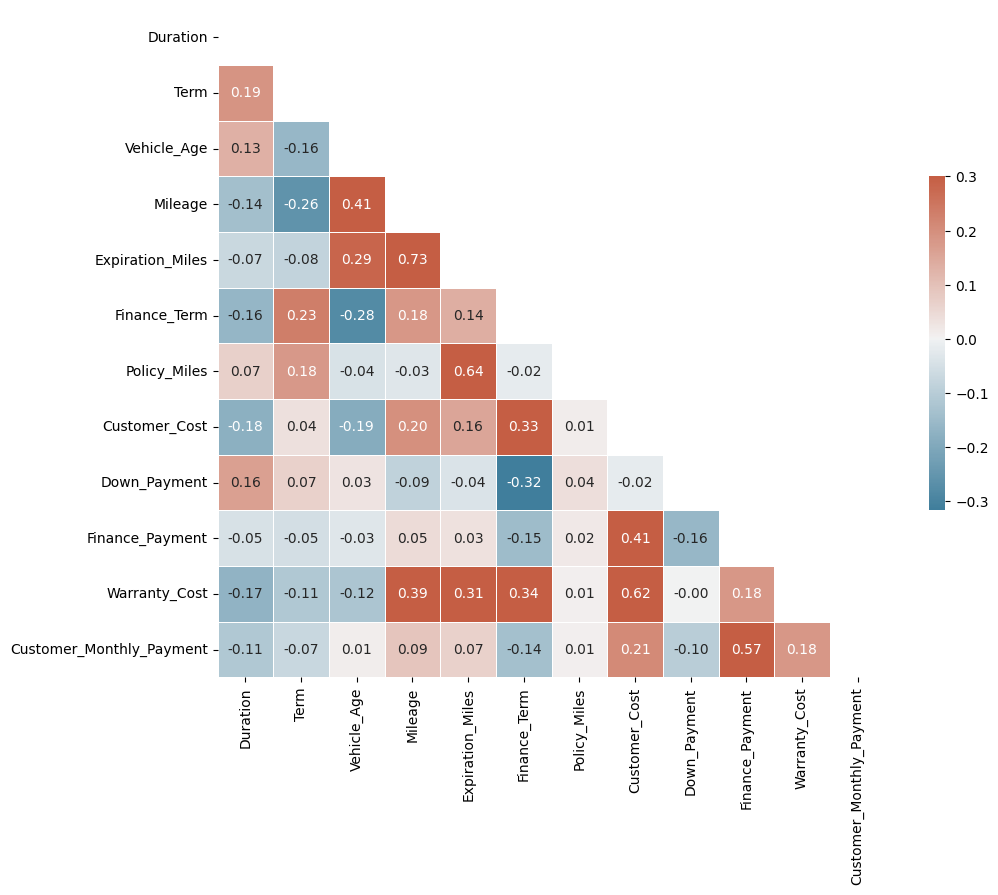

In [12]:
create_corr_plot(df_corr)

### 5) Data Visualization
    - Insert some question that you want to answer with the visualized data
    - Distributions, Histograms, Kernel Density Functions (KDE), Barcharts, Violincharts

Status Counts: 
 Status
Cancelled        1321741
Active            501516
Not_Cancelled     157008
Name: count, dtype: int64


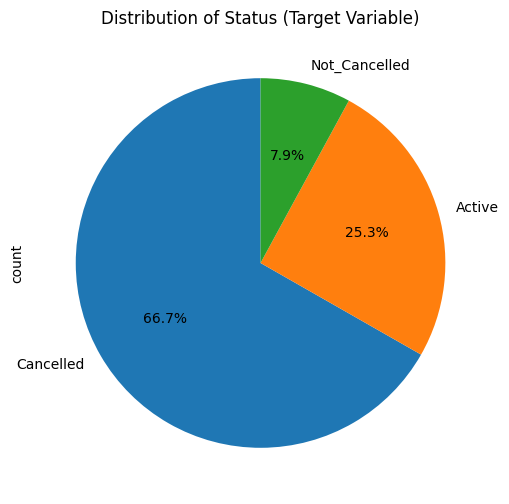

In [13]:
status_counts = df['Status'].value_counts()

print("Status Counts: \n", status_counts)

# Plot a pie chart
status_counts.plot.pie(autopct='%1.1f%%', startangle=90, figsize=(6, 6))

# Add a title
plt.title('Distribution of Status (Target Variable)')

# Display the pie chart
plt.show()

Make Counts: 
 Make
CHEVROLET       258591
FORD            257387
NISSAN          143366
TOYOTA          142784
HONDA            93691
                 ...  
DCX SPRINTER         2
EGIL                 2
DAEW                 1
237337               1
SPRINTER             1
Name: count, Length: 91, dtype: int64


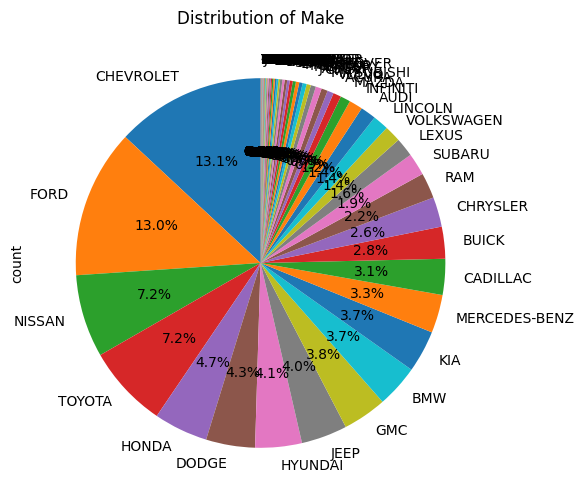

In [14]:
make_counts = df['Make'].value_counts()

print("Make Counts: \n", make_counts)

# Plot a pie chart
make_counts.plot.pie(autopct='%1.1f%%', startangle=90, figsize=(6, 6))

# Add a title
plt.title('Distribution of Make')

# Display the pie chart
plt.show()

Model Counts: 
 Model_Category1
SILVERADO     56900
F150          53493
GRAND         43591
ESCAPE        37177
EQUINOX       36508
              ...  
E400HYBRID        1
AEROSTAR          1
NUBIRA            1
LXI350            1
B-SERIES          1
Name: count, Length: 1704, dtype: int64


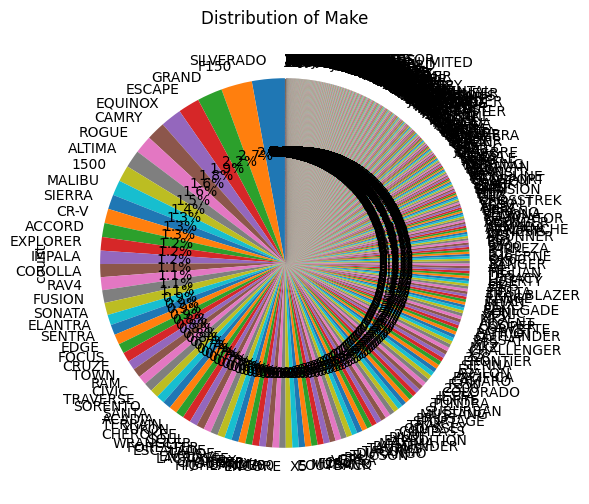

In [15]:
model_counts = df['Model_Category1'].value_counts()

print("Model Counts: \n", model_counts)

# Plot a pie chart
model_counts.plot.pie(autopct='%1.1f%%', startangle=90, figsize=(6, 6))

# Add a title
plt.title('Distribution of Make')

# Display the pie chart
plt.show()

New and Used Counts: 
 New_Used
USED         1467439
NEW           434641
U              39630
N              32035
PROGRAM         3190
USEASNEW        2923
USEDASNEW          3
Name: count, dtype: int64


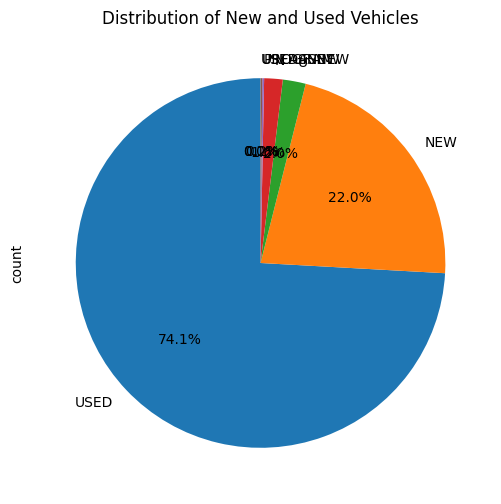

In [16]:
new_used_counts = df['New_Used'].value_counts()

print("New and Used Counts: \n", new_used_counts)

# Plot a pie chart
new_used_counts.plot.pie(autopct='%1.1f%%', startangle=90, figsize=(6, 6))

# Add a title
plt.title('Distribution of New and Used Vehicles')

# Display the pie chart
plt.show()

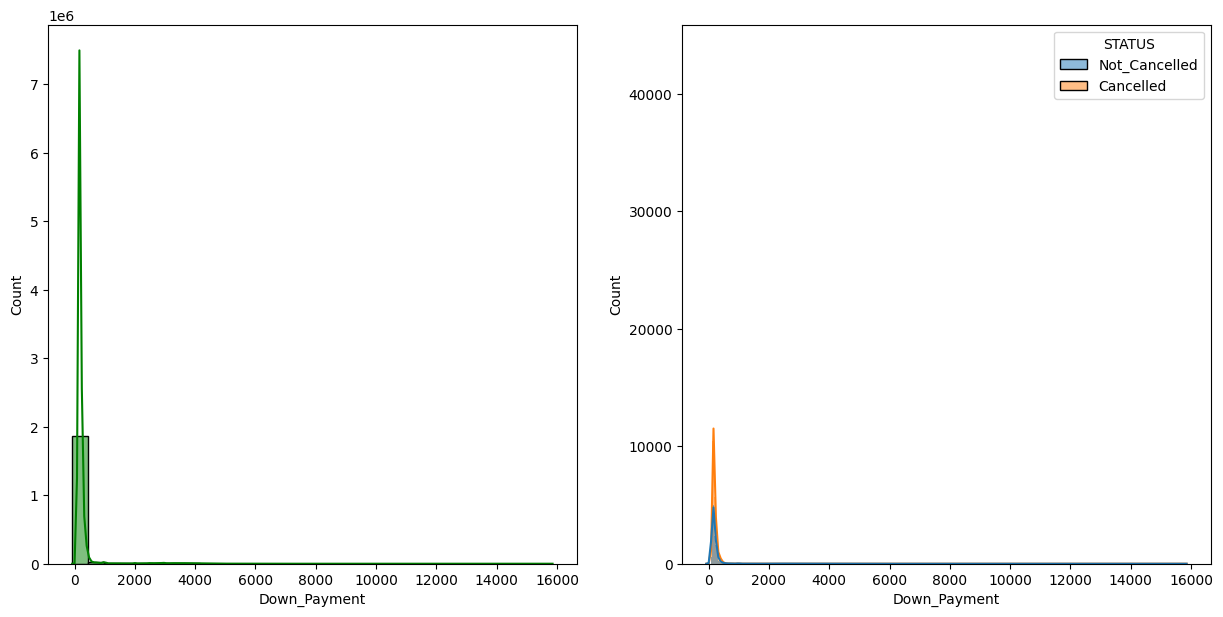

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
plt.subplot(121)
sns.histplot(data=df, x='Down_Payment', bins=30, kde=True, color='g')
plt.subplot(122)
sns.histplot(data=df, x='Down_Payment', kde=True, hue='Status')
plt.show()

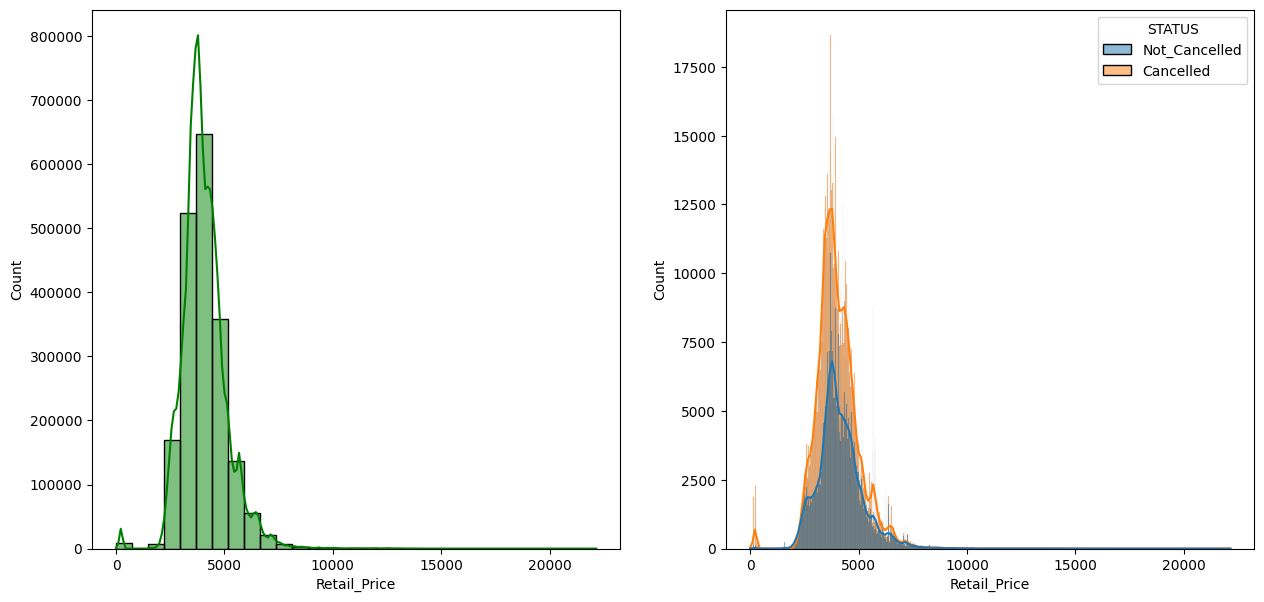

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
plt.subplot(121)
sns.histplot(data=df, x='Retail_Price', bins=30, kde=True, color='g')
plt.subplot(122)
sns.histplot(data=df, x='Retail_Price', kde=True, hue='Status')
plt.show()

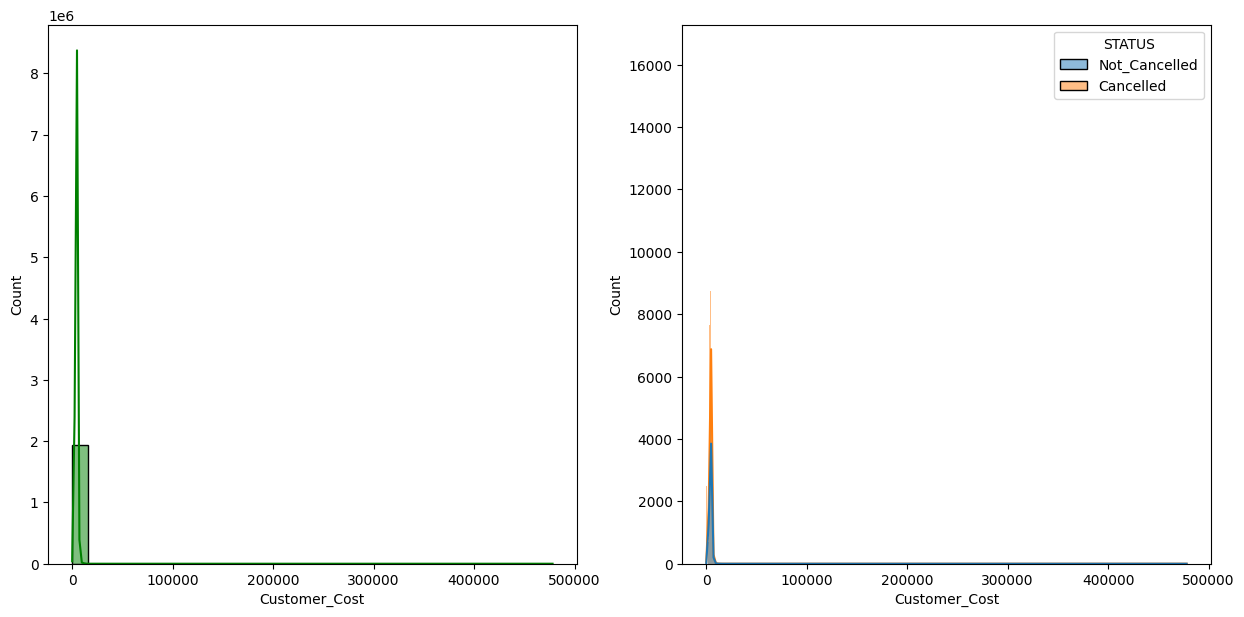

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
plt.subplot(121)
sns.histplot(data=df, x='Customer_Cost', bins=30, kde=True, color='g')
plt.subplot(122)
sns.histplot(data=df, x='Customer_Cost', kde=True, hue='Status')
plt.show()

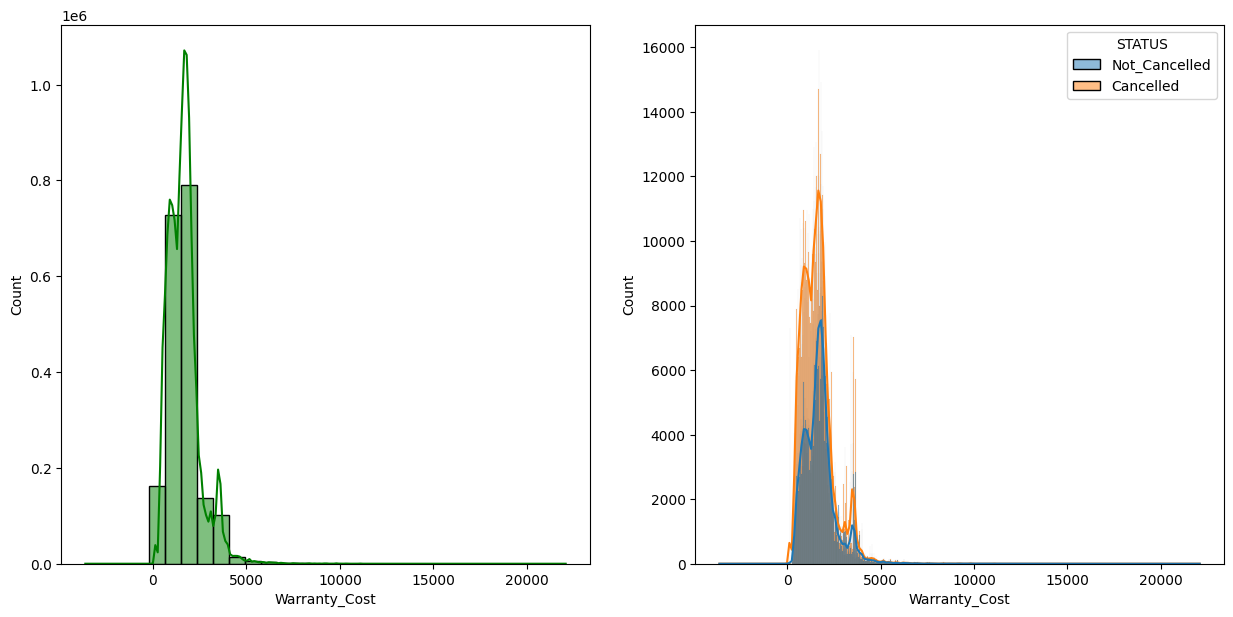

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
plt.subplot(121)
sns.histplot(data=df, x='Warranty_Cost', bins=30, kde=True, color='g')
plt.subplot(122)
sns.histplot(data=df, x='Warranty_Cost', kde=True, hue='Status')
plt.show()

### 6) Data Processing (for Modeling)
    - Filling missing data
    - LabelEncoding the Categorical Variables
    - Scaling the data (Central Limit Theorem)
    - Define the Features and Target Variable
    - Splitting the dataframe into 80/20

In [17]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [18]:
# Split into numerical and categorical columns
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()

In [19]:
print("Numerical Columns: \n", numerical_columns)

Numerical Columns: 
 ['Duration', 'Term', 'Vehicle_Age', 'Mileage', 'Expiration_Miles', 'Finance_Term', 'Policy_Miles', 'Customer_Cost', 'Down_Payment', 'Finance_Payment', 'Warranty_Cost', 'Paid_In_Full', 'Customer_Monthly_Payment']


In [20]:
print("Categorical Columns: \n", categorical_columns)

Categorical Columns: 
 ['Contract_Number', 'Make', 'Model', 'New_Used', 'Status', 'Model_Category1']


In [21]:
print(len(numerical_columns), len(categorical_columns))

13 6


In [22]:
"""num_cols = ['Deductible', 
            'Term_Months', 
            'Term_Mileage', 
            'Model_Year',
            'Vehicle_Age', 
            'Sale_Odometer',
            'Effective_Odometer',  
            'Expire_Odometer',
            'Retail_Amount',
            'Admin_Cost',
            'Dealer_Cost', 
            'Base Reserve',
            'Claim Reserve', 
            'Insurance Fee',
            'Admin Fees', 
            'Gray Claim Fee'
    ]   
"""
num_cols = ['Duration', 
                #'Term',
                #'Vehicle_Year',
                'Vehicle_Age',
                'Mileage',
                'Expiration_Miles',
                'Finance_Term',
                'Policy_Miles',
                'Customer_Cost',
                'Down_Payment',
                'Finance_Payment',
                #'Retail_Price', 
                'Warranty_Cost'
                'Paid_In_Full',
                'Customer_Monthly_Payment',
]    

In [23]:
"""cat_cols = [#'Sales_Channel', 
            'Insurance_Type', 
            'Insurer_Code', 
            'Product_type_desc', 
            'Vehicle_Age',
            'Coverage_Group',
            'Deductible_Type',  
            'Customer_State',
            'New_Used',
            'GPW_NUP', 
            'Make',
            'Model_Category1', 
            'Vehicle_Class', 
            'Dealer_State', 
            'Status', 
    ]"""

cat_cols = [#'Contract_Number',
            'Term',
            'Make',
            'Model_Category1',
            'New_Used',
            'Status',
]

In [24]:
print(len(num_cols), len(cat_cols))

11 5


In [25]:
# columns to be dropped
"""drop_cols = ['Contract_Number', 
                'Contract_Id',
                'Dealer_Number',
                'Dealer_Name',
                'Dealer_Status', 
                'Inserted_Date',
                'Cancel_Effect_Date',
                'Effective_Date',
                'Sale_Date',
                'In_Service_Date',
                'OEMExpireDate',
                'Active_Date', 
                'Expiration_Date',
                'Coverage_Termination_Date',
        ]
"""
drop_cols = ['Contract_Number',
             'Sale_Date',
             'Cancel_Date',
        ]

#df = df.drop(drop_cols, axis=1)

In [26]:
""" INSERT FINAL DATAFRAME WITH PREDICTOR VARIABLES AND TARGET VARIABLE HERE """
"""
predictor_columns = [#'Sales_Channel',
                    'Insurance_Type',
                    'Insurer_Code',
                    'Product_type_desc',
                    'Coverage_Group',
                    'Deductible',
                    'Deductible_Type',
                    'Duration',
                    'Term_Months',
                    'Term_Mileage',
                    'Customer_State',
                    'New_Used',
                    'GPW_NUP',
                    'Make',
                    'Model_Category1',
                    'Model_Year',
                    'Vehicle_Age',
                    'Vehicle_Class',
                    'Sale_Odometer',
                    'Effective_Odometer',
                    'Expire_Odometer',
                    'Retail_Amount',
                    'Admin_Cost',
                    'Dealer_Cost',
                    'Base Reserve',
                    'Claim Reserve',
                    'Insurance Fee',
                    'Admin Fees',
                    'Gray Claim Fee',
                    'Dealer_State',
                    'Status',
]
"""
predictor_columns = [
        'Duration', 
        'Term',
        #'Vehicle_Year',
        'Vehicle_Age',
        'Mileage',
        'Expiration_Miles',
        'Finance_Term',
        'Policy_Miles',
        'Customer_Cost',
        'Down_Payment',
        'Finance_Payment',
        #'Retail_Price', 
        'Warranty_Cost',
        'Make',
        'Model_Category1',
        'New_Used',
        'Paid_In_Full',
        'Customer_Monthly_Payment',
        'Status',
]

print(len(predictor_columns))

17


In [27]:
# Set the dataframe to only have the predictor columns
df = df[predictor_columns]

In [28]:
df.head()

,Duration,Term,Vehicle_Age,Mileage,Expiration_Miles,Finance_Term,Policy_Miles,Customer_Cost,Down_Payment,Finance_Payment,Warranty_Cost,Make,Model_Category1,New_Used,Paid_In_Full,Customer_Monthly_Payment,Status
0,0.0,0.0,22.0,191978,251978,12,60000.0,3289.0,195.0,171.89,939.0,CHEVROLET,SUBURBAN,N,NaN,NaN,Not_Cancelled
1,0.0,0.0,18.0,44371,92371,12,48000.0,3746.0,250.0,0.00,2078.0,BMW,525,N,NaN,NaN,Not_Cancelled
2,0.0,0.0,16.0,29877,89877,12,60000.0,2993.0,195.0,0.00,909.0,GMC,SIERRA,N,NaN,NaN,Not_Cancelled
3,0.0,0.0,17.0,83211,143211,12,60000.0,3895.0,205.0,0.00,1565.0,BMW,X3,U,NaN,NaN,Not_Cancelled
4,0.0,48.0,22.0,40980,140980,18,100000.0,5875.0,1500.0,0.00,3465.0,MERZ,MESL5,N,NaN,NaN,Cancelled


In [ ]:
df_evaluation = df[df['Status'] == 'Pending']

In [ ]:
df_evaluation.head()

,Insurance_Type,Insurer_Code,Product_type_desc,Coverage_Group,Deductible,Deductible_Type,Sale_Date,Duration,Term_Months,Term_Mileage,...,Retail_Amount,Admin_Cost,Dealer_Cost,Base Reserve,Claim Reserve,Insurance Fee,Admin Fees,Gray Claim Fee,Dealer_State,Status
91,XOL,WIC,VSC,DIRECTD,100.0,PerRepair,2020-05-11,57,60,100000,...,4280.0,643.0,643.0,295.0,295.0,31.00,317.0,15.0,MO,Pending
137,XOL,WIC,VSC,DIRECTD,100.0,PerRepair,2020-07-27,55,60,100000,...,3755.0,1056.0,1056.0,708.0,708.0,31.00,317.0,15.0,MO,Pending
206,XOL,WIC,VSC,DIRECTD,100.0,PerRepair,2020-06-25,56,72,125000,...,3117.0,510.0,510.0,162.0,162.0,31.00,317.0,15.0,MO,Pending
257,XOL,WIC,VSC,DIRECTD,100.0,PerRepair,2020-09-29,53,72,75000,...,3943.0,418.0,418.0,84.0,84.0,30.22,303.0,15.0,MO,Pending
281,XOL,WIC,VSC,DIRECTD,100.0,PerRepair,2020-10-12,52,72,125000,...,3975.0,496.0,496.0,162.0,162.0,30.22,303.0,15.0,MO,Pending


In [ ]:
# Drop rows where Status is "Pending" (since it is not a valid target). These should be the values that to be predicted in the future.
df = df[df['Status'] != 'Pending']

In [29]:
df = df.drop_duplicates()

In [30]:
df = df.dropna()

In [31]:
df_active = df[df['Status'] == 'Active']

In [32]:
df = df[df['Status'] != 'Active']

In [33]:
df.shape

(1243502, 17)

In [34]:
df.head(10)

,Duration,Term,Vehicle_Age,Mileage,Expiration_Miles,Finance_Term,Policy_Miles,Customer_Cost,Down_Payment,Finance_Payment,Warranty_Cost,Make,Model_Category1,New_Used,Paid_In_Full,Customer_Monthly_Payment,Status
100533,13.0,60.0,20.0,78300,129300,24,50000.0,3973.52,199.00,157.27,981.0,FORD,TAURUS,USED,0.0,157.27,Cancelled
100534,42.0,60.0,20.0,57207,108207,24,50000.0,3288.00,169.00,129.96,703.0,TOYOTA,CAMRY,USED,0.0,129.96,Cancelled
100535,48.0,48.0,16.0,98614,147614,24,48000.0,3921.00,196.05,155.21,759.0,TOYOTA,COROLLA,USED,0.0,155.21,Not_Cancelled
100536,18.0,48.0,16.0,36098,117098,21,80000.0,4479.25,223.96,202.63,730.0,MITSUBISHI,OUTLANDER,USED,0.0,202.63,Cancelled
100538,18.0,60.0,16.0,72500,133500,24,60000.0,3334.60,167.00,131.98,1041.0,DODGE,CALIBER,USED,0.0,131.98,Cancelled
100539,48.0,48.0,16.0,30123,106123,18,75000.0,3183.00,3183.00,0.00,1233.0,CHEVROLET,TRAILBLAZER,USED,1.0,0.00,Not_Cancelled
100541,29.0,84.0,6.0,8115,101000,36,100000.0,4200.00,275.00,109.03,785.0,CHRYSLER,PACIFICA,NEW,0.0,108.54,Cancelled
100544,7.0,60.0,11.0,40945,141945,30,100000.0,5217.00,260.85,165.20,1467.0,FORD,FIESTA,USED,0.0,165.20,Cancelled
100545,35.0,60.0,17.0,201962,302962,36,100000.0,4663.00,233.15,123.05,1787.0,HONDA,PILOT,USED,0.0,123.05,Cancelled
100546,6.0,60.0,18.0,42095,93095,24,50000.0,4240.66,212.03,167.86,991.0,CHEVROLET,IMPALA,USED,0.0,167.86,Cancelled


In [35]:
df['Status'].value_counts()

Status
Cancelled        1153709
Not_Cancelled      89793
Name: count, dtype: int64

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1243502 entries, 100533 to 1980264
Data columns (total 17 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   Duration                  1243502 non-null  float64
 1   Term                      1243502 non-null  float64
 2   Vehicle_Age               1243502 non-null  float64
 3   Mileage                   1243502 non-null  int64  
 4   Expiration_Miles          1243502 non-null  int64  
 5   Finance_Term              1243502 non-null  int64  
 6   Policy_Miles              1243502 non-null  float64
 7   Customer_Cost             1243502 non-null  float64
 8   Down_Payment              1243502 non-null  float64
 9   Finance_Payment           1243502 non-null  float64
 10  Warranty_Cost             1243502 non-null  float64
 11  Make                      1243502 non-null  object 
 12  Model_Category1           1243502 non-null  object 
 13  New_Used                  1

In [37]:
categorical_columns_le = [#'Sales_Channel',
                          'Insurance_Type', 'Insurer_Code', 'Product_type_desc', 
                          'Coverage_Group', 'Deductible_Type',  
                          'Customer_State', 'New_Used', 'GPW_NUP', 
                          'Make', 'Model', 'Model_Category1', 
                          'Vehicle_Class', 
                          'Dealer_State', 
                          'Status', ]

#categorical_columns_le = ['Make', 'Model', 'State']

# Label Encoding for categorical variables
label_encoders = {}
for column in cat_cols:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

In [45]:
df.head()

,Duration,Term,Vehicle_Age,Mileage,Expiration_Miles,Finance_Term,Policy_Miles,Customer_Cost,Down_Payment,Finance_Payment,Retail_Price,Warranty_Cost,Make,Model_Category1,New_Used,Paid_In_Full,Customer_Monthly_Payment,Status
102053,60.0,6,12.0,82001,133001,36,50000.0,3627.0,180.00,95.75,3627.0,1627.0,6,85,5,0.0,95.75,1
102054,60.0,6,12.0,76000,152000,36,75000.0,4192.0,209.60,110.62,3992.0,2091.0,6,122,5,0.0,110.62,1
102056,5.0,7,15.0,99880,175880,36,75000.0,3503.0,175.15,92.44,3303.0,1303.0,39,810,5,0.0,92.44,0
102057,1.0,7,12.0,126650,202650,36,75000.0,3547.0,177.35,93.60,3447.0,1447.0,14,28,5,0.0,93.60,0
102058,1.0,6,8.0,37916,101000,36,100000.0,2824.0,141.20,74.52,2924.0,992.0,12,368,1,0.0,149.04,0


In [38]:
# Feature and Target Variables
X = df.drop('Status', axis=1)
y = df['Status']

In [39]:
""" 
Note: we use fit_transform() on the training data, but only transform() on the test data.
This is to avoid data leakage from the test set into the training set.
"""

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standard Scaling (for Logistic Regression and Neural Network)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Unsupervised Leaning 
- PCA
- SHAP
- dimenionality reduction techinique

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
""" We must sclaed the full X data for the dimensionality reduction techniques """
X_scaled = scaler.fit_transform(X)

In [ ]:
# Apply PCA
pca = PCA(n_components=12)  # Reduce to 2 dimensions
X_pca = pca.fit_transform(X_scaled)

### 7) Data Modeling
    - Spliting the dataframe 80/20
    - Applying Machine Learning Model (Unsupervised and Supervised Learning)
    - Model Evaluation (Confusion Matrix, Precision/Recall/F1-Score, AUC/ROC Curve, K-Fold Cross-Validation)
 

In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [ ]:
#pip install scikit-learn xgboost flaml lightgbm

In [49]:
""" USE FLAML LIBRARY TO FIND THE BEST MODEL """

from flaml import AutoML, tune

automl = AutoML()

# Specify automl goal and constraints
automl_settings = {
    "time_budget": 1_000,  # In seconds
    "metric": "accuracy",
    "task": "classification",
}

# fit classification on the training data
clf = automl.fit(X_train=X_train, y_train=y_train, **automl_settings)

# Export the best model
print(automl.model) 

[flaml.automl.logger: 03-25 13:16:21] {1728} INFO - task = classification
[flaml.automl.logger: 03-25 13:16:21] {1739} INFO - Evaluation method: holdout
[flaml.automl.logger: 03-25 13:16:22] {1838} INFO - Minimizing error metric: 1-accuracy
[flaml.automl.logger: 03-25 13:16:22] {1955} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'sgd', 'catboost', 'lrl1']
[flaml.automl.logger: 03-25 13:16:22] {2258} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 03-25 13:16:22] {2393} INFO - Estimated sufficient time budget=49213s. Estimated necessary time budget=1213s.
[flaml.automl.logger: 03-25 13:16:22] {2442} INFO -  at 2.4s,	estimator lgbm's best error=0.0715,	best estimator lgbm's best error=0.0715
[flaml.automl.logger: 03-25 13:16:22] {2258} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 03-25 13:16:22] {2442} INFO -  at 2.5s,	estimator lgbm's best error=0.0715,	best estimator lgbm's best error=0.0715
[flaml.

In [42]:
""" MODEL PICKED FROM THE FLAML LIBRARY """

model_0 = XGBClassifier(base_score=None, booster=None, callbacks=[],
              colsample_bylevel=0.8562965621804284, colsample_bynode=None,
              colsample_bytree=0.9977278257445716, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy='lossguide', importance_type=None,
              interaction_constraints=None, learning_rate=0.09098795950135516,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=0, max_leaves=46,
              min_child_weight=0.7337267871344931,
              monotone_constraints=None, multi_strategy=None, n_estimators=955,
              n_jobs=-1, num_parallel_tree=None, random_state=None,)

model_1 = XGBClassifier(base_score=None, booster=None, callbacks=[],
              colsample_bylevel=0.8490633393816673, colsample_bynode=None,
              colsample_bytree=0.8053272322153723, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy='lossguide', importance_type=None,
              interaction_constraints=None, learning_rate=0.04263000030461294,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=0, max_leaves=279,
              min_child_weight=9.259146918880878,
              monotone_constraints=None, multi_strategy=None, n_estimators=442,
              n_jobs=-1, num_parallel_tree=None, random_state=None,)

model_2 = LGBMClassifier(colsample_bytree=0.7571905041593652,
               learning_rate=0.048628976882083515, max_bin=1023,
               min_child_samples=9, n_estimators=4591, n_jobs=-1,
               num_leaves=157, reg_alpha=0.01821589306006811,
               reg_lambda=1.717113611799, verbose=-1)

model_3 = LGBMClassifier(colsample_bytree=0.6650885070506689,
               learning_rate=0.031088425686058147, max_bin=1023,
               min_child_samples=5, n_estimators=6358, n_jobs=-1,
               num_leaves=136, reg_alpha=0.001975258376030875,
               reg_lambda=0.5449044286309448, verbose=-1)

model_4 = LGBMClassifier(learning_rate=0.056300903497383245, max_bin=1023,
               min_child_samples=35, n_estimators=281, n_jobs=-1,
               num_leaves=259, reg_alpha=2.43555687742282,
               reg_lambda=200.0323658136987, verbose=-1)

logit = LogisticRegression(
        penalty='l2',           # Regularization type
        C=0.1,                 # Inverse of regularization strength
        solver='lbfgs',         # Optimization algorithm
        max_iter=200,           # Maximum iterations
        class_weight='balanced', # Handle imbalanced classes
        random_state=42         # Random seed
)

### Light Gradient Boosting Model Metrics
    - Training data does NOT need to be scaled for tree based models

In [43]:
# 10-Fold Cross-Validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(model_4, X_train, y_train, cv=cv, scoring='roc_auc')

In [44]:
# Training the model
model_4.fit(X_train, y_train) # This creates feature_name_

LGBMClassifier(learning_rate=0.056300903497383245, max_bin=1023,
               min_child_samples=35, n_estimators=281, n_jobs=-1,
               num_leaves=259, reg_alpha=2.43555687742282,
               reg_lambda=200.0323658136987, verbose=-1)

In [45]:
""" 
Notes:
- Want to determine the characteristics of the characteristics of the contracts that are being cancelled (look at the probabilities)
- Monthly payment (Amount) in Moxylvie

"""

# Predictions
y_pred = model_4.predict(X_test)
y_pred_proba = model_4.predict_proba(X_test)[:, 1]

In [46]:
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9927865187514324


In [47]:
# Evaluation Metrics
conf_matrix = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

In [48]:
print('CV AUC Scores: ', cv_scores)
print('Confusion Matrix: ', conf_matrix)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print('F1 Score: ', f1)
print('ROC AUC: ', roc_auc)

CV AUC Scores:  [0.99777295 0.99805416 0.99792707 0.99784466 0.99796869 0.99769038
 0.99809065 0.99783284 0.99795468 0.99801723]
Confusion Matrix:  [[229037   1757]
 [    37  17870]]
Precision: 0.9105
Recall: 0.9979
F1 Score:  0.9522033356423509
ROC AUC:  0.9980404894202233


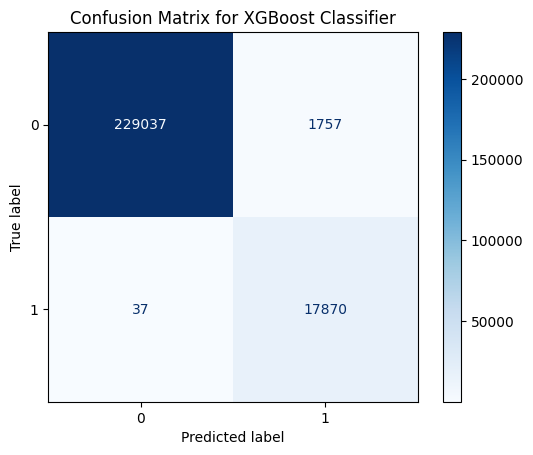

In [49]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for XGBoost Classifier')
plt.show()

In [50]:
# Get feature importances using .feature_importances_
feature_importances = model_4.feature_importances_
print("Feature Importances:", feature_importances)

Feature Importances: [1659 1505 3843 6848 5863  557 1492 5621 7111 3740 7720 3665 6933  149
    2 4478]


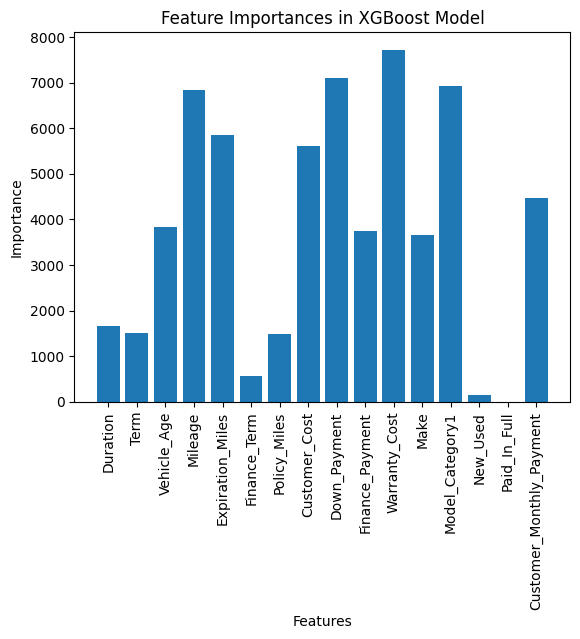

In [51]:
# Plot feature importances
plt.bar(range(len(feature_importances)), feature_importances)
plt.xticks(range(len(feature_importances)), X.columns, rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importances in XGBoost Model")
plt.show()

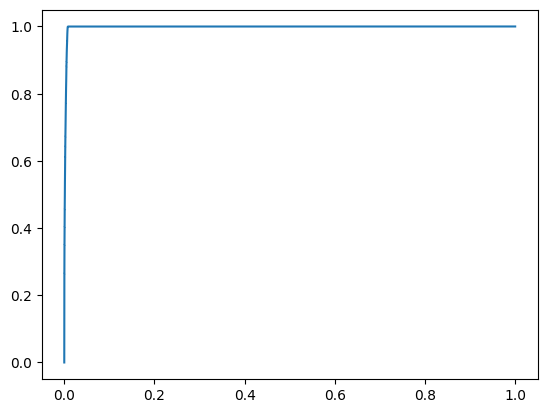

In [52]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc:.2f})')

### Logistic Regression (Comparison)
    - Recall you must use scaled training data for Log Reg

In [53]:
# 10-Fold Cross-Validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(logit, X_train, y_train, cv=cv, scoring='roc_auc')

In [54]:
# Training the logistic regression model
logit.fit(X_train, y_train) # This creates feature_name_

LogisticRegression(C=0.1, class_weight='balanced', max_iter=200,
                   random_state=42)

In [55]:
# Predictions
y_pred = logit.predict(X_test)
y_pred_proba = logit.predict_proba(X_test)[:, 1]

In [56]:
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.9629957257912112


In [57]:
# Evaluation Metrics
conf_matrix = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

In [58]:
print('CV AUC Scores: ', cv_scores)
print('Confusion Matrix: ', conf_matrix)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print('F1 Score: ', f1)
print('ROC AUC: ', roc_auc)

CV AUC Scores:  [0.98558916 0.98651264 0.98672425 0.98650305 0.98705274 0.98672204
 0.98746851 0.98615359 0.98698746 0.98597757]
Confusion Matrix:  [[221765   9029]
 [   174  17733]]
Precision: 0.6626
Recall: 0.9903
F1 Score:  0.7939734491481788
ROC AUC:  0.9913680111690721


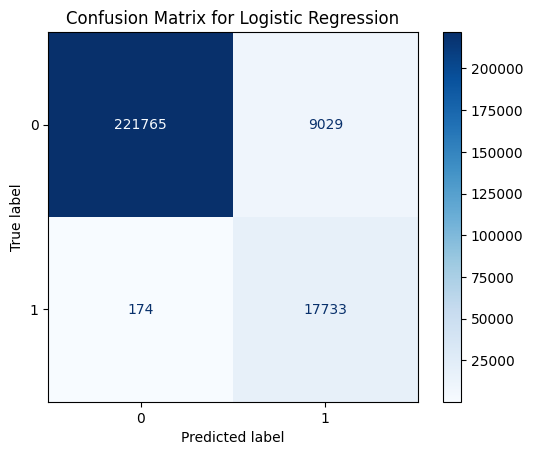

In [59]:
# Display the Confusion Matrix for Logistic Regression
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

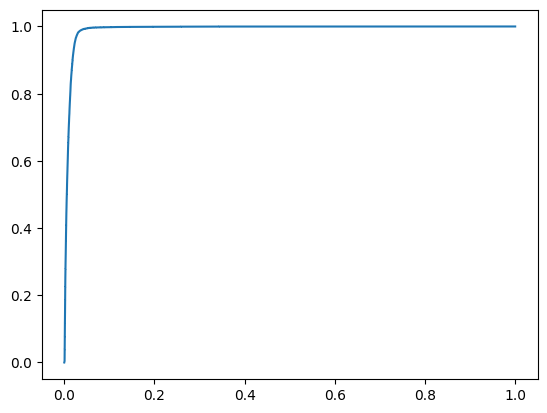

In [60]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc:.2f})')

In [77]:
# Create a DataFrame to display coefficients
coef_df = pd.DataFrame({
    'Feature': ['Intercept'] + list(X.columns),
    'Coefficient (log-odds)': [logit.intercept_[0]] + list(logit.coef_[0]),
    'Odds Ratio (exp(coef))': [np.exp(logit.intercept_[0])] + list(np.exp(logit.coef_[0]))
})

In [ ]:
# Add p-values (requires statsmodels for proper calculation)
# For demonstration, we have a placeholder
coef_df['Significance'] = ['p < 0.001' for _ in range(len(coef_df))]

print("Logistic Regression Coefficients:")
print(coef_df.to_string(index=False))
print("\nModel Accuracy:", logit.score(X_test, y_test))


Logistic Regression Coefficients:
                 Feature  Coefficient (log-odds)  Odds Ratio (exp(coef)) Significance
               Intercept                0.000187                1.000187    p < 0.001
                Duration                0.103080                1.108580    p < 0.001
                    Term                0.000608                1.000609    p < 0.001
             Vehicle_Age                0.006248                1.006268    p < 0.001
                 Mileage               -0.000012                0.999988    p < 0.001
        Expiration_Miles                0.000013                1.000013    p < 0.001
            Finance_Term               -0.001239                0.998761    p < 0.001
            Policy_Miles               -0.000013                0.999987    p < 0.001
           Customer_Cost               -0.001398                0.998603    p < 0.001
            Down_Payment                0.001939                1.001941    p < 0.001
         Finance_Pay

In [80]:

# Interpretation example
print("\nInterpretation Example:")
print(f"- For each 1-unit increase in 'mean radius', the log-odds of the positive class increases by {logit.coef_[0][0]:.3f}")
print(f"  (Odds Ratio: {np.exp(logit.coef_[0][0]):.3f}, meaning the odds increase by {(np.exp(logit.coef_[0][0])-1)*100:.1f}%)")
print(f"- The intercept represents the baseline log-odds when all features are zero")


Interpretation Example:
- For each 1-unit increase in 'mean radius', the log-odds of the positive class increases by 0.103
  (Odds Ratio: 1.109, meaning the odds increase by 10.9%)
- The intercept represents the baseline log-odds when all features are zero


Saving the model into a pickle file

In [61]:

base_dir = 'C:\\Users\\RaymondGreenfield\\OneDrive - endurancedirect.com\\Documents\\Actuarial_Work\\src'
model_save_file = Path(base_dir) / 'Artifacts' / 'cancellation_model.pkl'


In [62]:
# Save the model to a .pkl file
with open(model_save_file, 'wb') as f:
    pickle.dump(model_4, f)

print("Model saved as 'cancellation_model.pkl'")

Model saved as 'cancellation_model.pkl'


### 8) Apply the Model to the Evaluation dataset of the Active Contracts

In [63]:
df_active.head()

,Duration,Term,Vehicle_Age,Mileage,Expiration_Miles,Finance_Term,Policy_Miles,Customer_Cost,Down_Payment,Finance_Payment,Warranty_Cost,Make,Model_Category1,New_Used,Paid_In_Full,Customer_Monthly_Payment,Status
100537,52.0,84.0,6.0,9501,101000,36,100000.0,4465.11,229.00,117.67,728.0,CHEVROLET,EQUINOX,NEW,0.0,117.67,Active
100540,48.0,48.0,17.0,89050,165050,30,75000.0,2917.26,145.86,92.38,1269.0,INFINITI,QX56,USED,0.0,92.38,Active
100542,49.0,60.0,17.0,88523,139523,24,50000.0,3776.00,188.80,149.47,995.0,HONDA,ACCORD,USED,0.0,149.47,Active
100548,42.0,48.0,14.0,55640,98640,24,42000.0,3435.46,159.00,136.52,1199.0,ACURA,RL,USED,0.0,136.52,Active
100550,42.0,48.0,18.0,112572,161572,24,48000.0,4744.00,189.76,189.76,2204.0,MERCEDES-BENZ,ML,USED,0.0,189.76,Active


In [70]:
# Label Encoding for categorical variables
label_encoders = {}
for column in cat_cols[:-1]:
    le = LabelEncoder()
    df_active[column] = le.fit_transform(df_active[column])
    label_encoders[column] = le

In [65]:
df_active.shape

(487455, 17)

In [64]:
# Load the saved model
with open(model_save_file, 'rb') as f:
    model = pickle.load(f)

In [64]:
print(model.__dict__)  # Should show fitted parameters like 'n_features_in_'

{'boosting_type': 'gbdt', 'objective': None, 'num_leaves': 259, 'max_depth': -1, 'learning_rate': 0.056300903497383245, 'n_estimators': 281, 'subsample_for_bin': 200000, 'min_split_gain': 0.0, 'min_child_weight': 0.001, 'min_child_samples': 35, 'subsample': 1.0, 'subsample_freq': 0, 'colsample_bytree': 1.0, 'reg_alpha': 2.43555687742282, 'reg_lambda': 200.0323658136987, 'random_state': None, 'n_jobs': -1, 'importance_type': 'split', '_Booster': <lightgbm.basic.Booster object at 0x000001A712F3FE80>, '_evals_result': {}, '_best_score': defaultdict(<class 'collections.OrderedDict'>, {}), '_best_iteration': 0, '_other_params': {'max_bin': 1023, 'verbose': -1}, '_objective': 'binary', 'class_weight': None, '_class_weight': None, '_class_map': {0: 0, 1: 1}, '_n_features': 17, '_n_features_in': 17, '_classes': array([0, 1]), '_n_classes': 2, 'max_bin': 1023, 'verbose': -1, '_le': LabelEncoder(), 'fitted_': True}


In [66]:
df_active = df_active[predictor_columns[:-1]]

In [67]:
df_active.columns

Index(['Duration', 'Term', 'Vehicle_Age', 'Mileage', 'Expiration_Miles',
       'Finance_Term', 'Policy_Miles', 'Customer_Cost', 'Down_Payment',
       'Finance_Payment', 'Warranty_Cost', 'Make', 'Model_Category1',
       'New_Used', 'Paid_In_Full', 'Customer_Monthly_Payment'],
      dtype='object')

In [71]:
def make_predictions(model, new_data):
    if not hasattr(model, 'feature_name_'):
        raise ValueError("Model not trained! Call fit() first")
    
    try:
        X_new = new_data[model.feature_name_]
        return model.predict(X_new)
    except KeyError as e:
        print(f"Missing features: {e}")
        print(f"Model expects: {model.feature_name_}")
        print(f"Data has: {new_data.columns.tolist()}")
        raise

# Usage:
predictions = make_predictions(model, df_active)

In [72]:
# Make predictions
predictions = model.predict(df_active)
prediction_probs = model.predict_proba(df_active)  # Probabilities (optional)

In [73]:
# Add predictions to the DataFrame
df_active['predicted_status'] = ['Cancelled' if x == 0 else 'Not_Cancelled' for x in predictions]
df_active['cancellation_probability'] = prediction_probs[:, 1]  # Prob of class 1 (cancelled)

In [74]:
df_active.head(100)

,Duration,Term,Vehicle_Age,Mileage,Expiration_Miles,Finance_Term,Policy_Miles,Customer_Cost,Down_Payment,Finance_Payment,Warranty_Cost,Make,Model_Category1,New_Used,Paid_In_Full,Customer_Monthly_Payment,predicted_status,cancellation_probability
100537,52.0,6,6.0,9501,101000,36,100000.0,4465.11,229.00,117.67,728.0,6,242,1,0.0,117.67,Cancelled,0.006435
100540,48.0,3,17.0,89050,165050,30,75000.0,2917.26,145.86,92.38,1269.0,18,500,3,0.0,92.38,Not_Cancelled,0.849251
100542,49.0,4,17.0,88523,139523,24,50000.0,3776.00,188.80,149.47,995.0,14,90,3,0.0,149.47,Not_Cancelled,0.799267
100548,42.0,3,14.0,55640,98640,24,42000.0,3435.46,159.00,136.52,1199.0,0,526,3,0.0,136.52,Not_Cancelled,0.681118
100550,42.0,3,18.0,112572,161572,24,48000.0,4744.00,189.76,189.76,2204.0,28,440,3,0.0,189.76,Not_Cancelled,0.571572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102135,1.0,3,14.0,143700,204700,30,60000.0,4873.00,157.20,157.19,1931.0,21,317,3,0.0,157.19,Cancelled,0.000057
102136,1.0,3,10.0,90802,139802,30,48000.0,3669.00,118.36,118.36,1669.0,32,100,3,0.0,118.35,Cancelled,0.000062
102137,1.0,3,8.0,106027,155027,30,48000.0,4040.00,130.33,130.33,1840.0,6,634,3,0.0,130.32,Cancelled,0.000065
102138,1.0,3,8.0,80329,156329,29,75000.0,4468.00,148.94,148.94,2068.0,32,476,3,0.0,148.93,Cancelled,0.000076


Map the Make, Model, and Model_Category1 back to the original values

In [75]:
for column in cat_cols:
    if column in label_encoders:
        # Find values not in the encoder's classes
        unique_values = df_active[column].unique()
        valid_values = np.arange(len(label_encoders[column].classes_))
        unseen_mask = ~np.isin(df_active[column], valid_values)
        
        # Inverse transform valid values
        df_active.loc[~unseen_mask, column] = label_encoders[column].inverse_transform(
            df_active.loc[~unseen_mask, column]
        )
        
        # Handle unseen values (you can choose to keep encoded or set to 'Unknown')
        df_active.loc[unseen_mask, column] = 'Unknown'  # or np.nan or keep encoded

In [80]:
df_active.head()

,Duration,Term,Vehicle_Age,Mileage,Expiration_Miles,Finance_Term,Policy_Miles,Customer_Cost,Down_Payment,Finance_Payment,Retail_Price,Warranty_Cost,Make,Model_Category1,New_Used,Paid_In_Full,Customer_Monthly_Payment,predicted_status,cancellation_probability
102055,69.0,84,8.0,18342,101000,36,100000.0,3684.0,184.20,97.22,3084.0,1152.0,RAM,3500,NEW,0.0,0.00,Cancelled,0.902972
102078,68.0,72,14.0,73012,149012,36,75000.0,3585.0,179.25,94.60,3585.0,910.0,JEEP,GRAND,USED,0.0,94.60,Cancelled,0.888381
102099,66.0,96,9.0,2115,101000,18,100000.0,2064.0,2064.00,0.00,2564.0,632.0,SUBARU,CROSSTREK,NEW,1.0,0.00,Not_Cancelled,0.321726
102111,60.0,60,9.0,50100,111100,24,60000.0,3169.0,3169.00,0.00,3869.0,1687.0,MERCEDES-BENZ,GL,USED,1.0,0.00,Cancelled,0.976916
102169,71.0,72,9.0,25484,100000,12,100000.0,3400.0,3400.00,0.00,4181.0,1706.0,AUDI,Q5,NEW,1.0,269.17,Cancelled,0.954723


Export the predictions dataframe for PowerBI dashboard analytics

In [76]:
# Exporting the predictions to a CSV file
predictions_file = Path(base_dir) / 'data' / 'predictions_04142025.csv'
df_active.to_csv(predictions_file, index=False)

### 9) Calculating the Expected Loss from the Predicted Cancelled Contracts
    - Use the Customer Cost as the Payment
    - Using the predicted probabilities we can calculate a total expected loss from the canceled contracts
    - This will also be done in the PowerBI Dashboard


### Comparison of Four Models: Logistic Regression, Random Forest, XGBoost, Support Vector Machine

In [ ]:
# Models
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest':       RandomForestClassifier(random_state=42),
    'XGBoost':             LGBMClassifier(colsample_bytree=0.6650885070506689,
                                            learning_rate=0.031088425686058147, max_bin=1023,
                                            min_child_samples=5, n_estimators=6358, n_jobs=-1,
                                            num_leaves=136, reg_alpha=0.001975258376030875,
                                            reg_lambda=0.5449044286309448, verbose=-1),
    'Support Vector Machine':                    SVC(kernel='rbf', random_state=42)
}

# try SVM


# Model Evaluation
results = {}
for name, model in models.items():
    if name == 'Logistic Regression' or name == 'Neural Network':
        X_train_model = X_train_scaled
        X_test_model = X_test_scaled
    else:
        X_train_model = X_train
        X_test_model = X_test
    
    # 10-Fold Cross-Validation
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train_model, y_train, cv=cv, scoring='roc_auc')
    
    # Training the model
    model.fit(X_train_model, y_train)
    
    # Predictions
    y_pred = model.predict(X_test_model)
    y_pred_proba = model.predict_proba(X_test_model)[:, 1]
    
    # Evaluation Metrics
    conf_matrix = confusion_matrix(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Store results
    results[name] = {
        'CV AUC Scores': cv_scores,
        'Confusion Matrix': conf_matrix,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    }
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

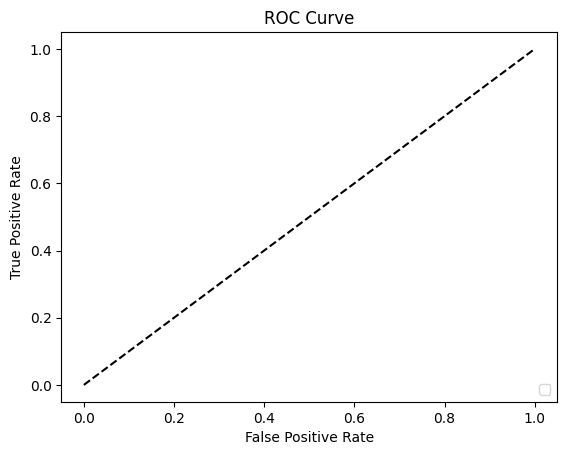

In [ ]:
# Plot ROC Curves
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [ ]:
# Print Results
for name, result in results.items():
    print(f"Model: {name}")
    print(f"10-Fold CV AUC Scores: {result['CV AUC Scores']}")
    print(f"Mean CV AUC: {np.mean(result['CV AUC Scores']):.2f}")
    print(f"Confusion Matrix:\n{result['Confusion Matrix']}")
    print(f"F1 Score: {result['F1 Score']:.2f}")
    print(f"ROC AUC: {result['ROC AUC']:.2f}")
    print("\n")

Model: Logistic Regression
Confusion Matrix:
[[2 0]
 [0 2]]
F1 Score: 1.00
ROC AUC: 1.00


Model: Random Forest
Confusion Matrix:
[[2 0]
 [0 2]]
F1 Score: 1.00
ROC AUC: 1.00


Model: XGBoost
Confusion Matrix:
[[2 0]
 [1 1]]
F1 Score: 0.67
ROC AUC: 0.88


Model: Neural Network
Confusion Matrix:
[[2 0]
 [0 2]]
F1 Score: 1.00
ROC AUC: 1.00




### Using the Pytorch library for a Neural Network

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
#pip install torch torchvision torchaudio

   ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
    --------------------------------------- 0.0/1.6 MB 660.6 kB/s eta 0:00:03
   --- ------------------------------------ 0.1/1.6 MB 1.7 MB/s eta 0:00:01
   --------------- ------------------------ 0.6/1.6 MB 4.8 MB/s eta 0:00:01
   ---------------------------------------  1.6/1.6 MB 9.9 MB/s eta 0:00:01
   ---------------------------------------- 1.6/1.6 MB 9.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
   ------ --------------------------------- 0.4/2.4 MB 25.6 MB/s eta 0:00:01
   ------------------------------ --------- 1.9/2.4 MB 29.4 MB/s eta 0:00:01
   ---------------------------------------  2.4/2.4 MB 19.5 MB/s eta 0:00:01
   ---------------------------------------- 2.4/2.4 MB 17.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Check PyTorch version
print(torch.__version__)

# Check if CUDA (GPU support) is available
print(torch.cuda.is_available())

# Print the CUDA version (if available)
print(torch.version.cuda)

2.6.0+cpu
False
None


In [ ]:

# Set random seed for reproducibility
torch.manual_seed(42)

# Generate a synthetic dataset
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader for training and testing
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define a simple feedforward neural network
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Hyperparameters
input_size = 20  # Number of features
hidden_size = 64  # Number of neurons in the hidden layer
output_size = 2  # Number of classes
learning_rate = 0.001
num_epochs = 100

# Initialize the model, loss function, and optimizer
model = NeuralNetwork(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Check if GPU is available and move the model to GPU if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


NeuralNetwork(
  (fc1): Linear(in_features=20, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)

In [ ]:

# Training loop
for epoch in range(num_epochs):
    model.train()
    for i, (inputs, labels) in enumerate(train_loader):
        # Move data to the same device as the model
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/100], Loss: 0.6059
Epoch [2/100], Loss: 0.5018
Epoch [3/100], Loss: 0.3944
Epoch [4/100], Loss: 0.2937
Epoch [5/100], Loss: 0.3453
Epoch [6/100], Loss: 0.3017
Epoch [7/100], Loss: 0.2916
Epoch [8/100], Loss: 0.3621
Epoch [9/100], Loss: 0.1668
Epoch [10/100], Loss: 0.1815
Epoch [11/100], Loss: 0.3344
Epoch [12/100], Loss: 0.3522
Epoch [13/100], Loss: 0.1131
Epoch [14/100], Loss: 0.1681
Epoch [15/100], Loss: 0.2788
Epoch [16/100], Loss: 0.1535
Epoch [17/100], Loss: 0.3949
Epoch [18/100], Loss: 0.2859
Epoch [19/100], Loss: 0.5244
Epoch [20/100], Loss: 0.1962
Epoch [21/100], Loss: 0.3346
Epoch [22/100], Loss: 0.1873
Epoch [23/100], Loss: 0.2362
Epoch [24/100], Loss: 0.2427
Epoch [25/100], Loss: 0.1686
Epoch [26/100], Loss: 0.1843
Epoch [27/100], Loss: 0.2515
Epoch [28/100], Loss: 0.2815
Epoch [29/100], Loss: 0.1717
Epoch [30/100], Loss: 0.2312
Epoch [31/100], Loss: 0.2552
Epoch [32/100], Loss: 0.0832
Epoch [33/100], Loss: 0.1869
Epoch [34/100], Loss: 0.2529
Epoch [35/100], Loss: 0

In [ ]:
# Evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


Test Accuracy: 81.50%
